In [23]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip3 install pickle5
import pickle5 as pickle
!pip3 install --upgrade pandas==1.3.4
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

!ls drive/'My Drive'

drive_path = 'drive/My Drive/'
drive_path = 'drive/MyDrive/Deep Learning/Lira'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'02450_Book - Copy.pdf'
 02450_Book.pdf
 02450Toolbox_Python
'Alfa Laval'
 Art
 aswinanilvarkey-cv.pdf
 Badminton
'Colab Notebooks'
 Coronapas.pdf
 CV
'Deep Learning'
 Denmark
 Documents
 DTU
'Event Feedback.gform'
 Expenditure.gsheet
'Flight Ticket.pdf'
'Garden Fresh'
 Germany
 LCD2
 Marksheet-1.pdf
'NDA Aswin.gdoc'
'NDA Aswin.pdf'
 photo
'QNet Ltd __ Receipt.pdf'
 R
'Rental Agreement.tif'
 Smartphone
'SRM Institute of Science and Technology__SRM Feekart.pdf'
 TN_KL-CHN_DF_0209_264448.pdf
'Untitled spreadsheet.gsheet'
'Vestas Badminton.gform'
'Vestas Badminton (Responses).gsheet'
'Vestas Badminton Weekly Session.gform'
'Vestas Badminton Weekly Session (Responses).gsheet'
 VID_52190412_020837_341.mp4
 Visa
 VN20200831_173740.mp4


In [24]:
with open(drive_path+'/dataset_1_classification.pickle', 'rb') as f:
    data = pickle.load(f)

No GPU available.
AE(
  (encoder_hidden_layer): Linear(in_features=3045, out_features=2000, bias=True)
  (encoder_output_layer): Linear(in_features=2000, out_features=2000, bias=True)
  (decoder_hidden_layer): Linear(in_features=2000, out_features=2000, bias=True)
  (decoder_output_layer): Linear(in_features=2000, out_features=3045, bias=True)
)


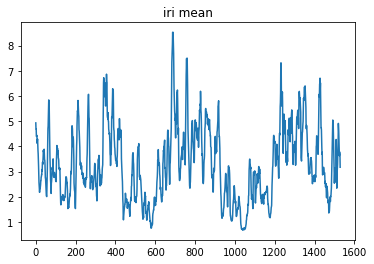

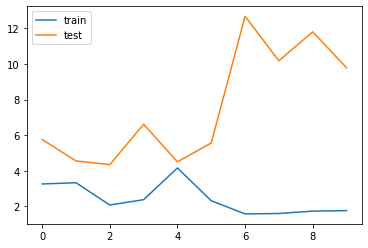

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
 
use_cuda = torch.cuda.is_available()
use_cuda = False
print("Running GPU.") if use_cuda else print("No GPU available.")

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=2000
        )
        self.encoder_output_layer = nn.Linear(
            in_features=2000, out_features=2000
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=2000, out_features=2000
        )
        self.decoder_output_layer = nn.Linear(
            in_features=2000, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
LEARNING_RATE = 3e-4
criterion = nn.MSELoss()   #<-- Your code here.   

BATCH_SIZE = 100
net = AE(input_shape=3045)

net.cuda()
print(net)

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

# train_dataset = moving_average(data['GM.acc.xyz.z'][8],10)

# test_dataset = moving_average(data['GM.acc.xyz.z'][1615],10)
train_dataset = data['z_smooth'][17]
test_dataset = data['z_smooth'][684]
iri_train = data['IRI_Sequence'][17]
iri_test = data['IRI_Sequence'][684]

train_dataset = [[],[]]
test_dataset = [[],[]]
iri_mean = []

for i in range(int(len(data['IRI_Sequence']))):
    mean = np.mean(data['IRI_Sequence'][i])
    iri_mean.append(mean)
    if mean <4:
        train_dataset[0].append(mean)
        train_dataset[1].append(data['z_smooth'][i])
    elif mean > 6:
        test_dataset[0].append(mean)
        test_dataset[1].append(data['z_smooth'][i])

train_np = np.asarray(train_dataset,dtype=object).T
test_np = np.asarray(test_dataset,dtype=object).T
df_train = pd.DataFrame(np.asarray(train_dataset,dtype=object).T,columns=['iri','z'])
plt.figure()
plt.plot(iri_mean)
plt.title('iri mean')

plt.figure()
plt.plot(iri_train)
plt.plot(iri_test)
plt.legend(['train','test'])

num_batches_train = len(df_train)

In [ ]:

epochs = 200
plt.figure()
iri = np.asarray([])
rec = np.asarray([])
train = np.asarray([])
    
for epoch in range(epochs):
    loss = 0
    rec_train = np.asarray([])
    for bt in range(int(num_batches_train)):
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        if(bt%100 == 0):
            print('Batch no:',bt,'IRI:',train_np[bt,0])
        batch_features = torch.Tensor(train_np[bt,1][20:-20]).cuda()
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = net(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        if epoch == epochs - 1:
            rec_train = np.concatenate((rec_train,outputs.cpu().detach().numpy()))
            train=np.concatenate((train,train_np[bt,1][20:-20]))
                
    loss = loss / len(train_dataset)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

plt.figure()
plt.plot(train)
plt.plot(rec_train)

Batch no: 0 IRI: 3.84370462905
Batch no: 100 IRI: 2.34046074255
Batch no: 200 IRI: 2.6283500621
Batch no: 300 IRI: 3.5319807470499995
Batch no: 400 IRI: 2.31874972295
Batch no: 500 IRI: 2.0487338900999994
Batch no: 600 IRI: 3.4707952427500004
Batch no: 700 IRI: 1.8625837947999997
Batch no: 800 IRI: 2.85504838875
Batch no: 900 IRI: 3.8086294117
Batch no: 1000 IRI: 3.8558651771499997
epoch : 1/200, loss = 20.874546
Batch no: 0 IRI: 3.84370462905
Batch no: 100 IRI: 2.34046074255
Batch no: 200 IRI: 2.6283500621
Batch no: 300 IRI: 3.5319807470499995
Batch no: 400 IRI: 2.31874972295
Batch no: 500 IRI: 2.0487338900999994
Batch no: 600 IRI: 3.4707952427500004
Batch no: 700 IRI: 1.8625837947999997
Batch no: 800 IRI: 2.85504838875
Batch no: 900 IRI: 3.8086294117
Batch no: 1000 IRI: 3.8558651771499997
epoch : 2/200, loss = 0.924546
Batch no: 0 IRI: 3.84370462905
Batch no: 100 IRI: 2.34046074255
Batch no: 200 IRI: 2.6283500621
Batch no: 300 IRI: 3.5319807470499995
Batch no: 400 IRI: 2.31874972295


In [ ]:
num_batches_test = len(test_np)
d_test = np.asarray([])
rec = np.asarray([])

for bt in range(int(num_batches_test)):
    # load it to the active device
    batch_features = torch.Tensor(test_np[bt,1][20:-20]).cuda()
    optimizer.zero_grad()
    
    # compute reconstructions
    outputs = net(batch_features)
    
    # compute training reconstruction loss
    train_loss = criterion(outputs, batch_features)
    
    # compute accumulated gradients
    train_loss.backward()
    
    # perform parameter update based on current gradients
    optimizer.step()
    
    # add the mini-batch training loss to epoch loss
    loss += train_loss.item()
    rec = np.concatenate((rec,outputs.cpu().detach().numpy()))
    d_test=np.concatenate((d_test,test_np[bt,1][20:-20]))

# compute the epoch training loss
loss = loss / len(test_dataset)
plt.figure()
plt.plot(d_test)
plt.plot(rec,'r')
plt.legend(['actual','reconstructed'])
plt.title('Test')

# display the epoch training loss
print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))